## 矢量加速

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.04077 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00053 sec'

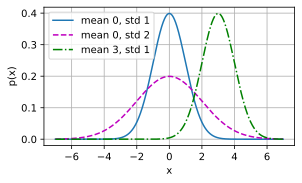

In [6]:
## 正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 线性回归从0开始

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 准备数据

In [4]:
## 合成数据
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

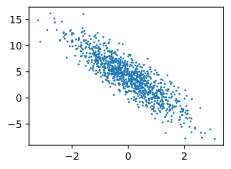

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 5
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7218, -0.8422],
        [-0.6173, -1.6186],
        [ 0.6334, -1.7529],
        [-0.6250, -0.8420],
        [-0.6343,  0.6137]]) 
 tensor([[ 8.5134],
        [ 8.4758],
        [11.4188],
        [ 5.8158],
        [ 0.8407]])


### 定义模型

In [10]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 定义损失函数

In [11]:
def square_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 模型训练

In [12]:
## 优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [35]:
# 模型初始化
w = torch.normal(0, 0.01, size=(2, 1,), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [36]:
lr = 0.01
num_epochs = 10
net = linreg
loss = square_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.344914
epoch 2, loss 0.008133
epoch 3, loss 0.000250
epoch 4, loss 0.000056
epoch 5, loss 0.000052
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051


In [37]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-6.6042e-05, -2.1362e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


## 简洁实现

In [38]:
## 准备数据
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [39]:
next(iter(data_iter))

[tensor([[ 0.1465,  0.5205],
         [ 0.4450, -0.1003],
         [-0.0732,  0.0173],
         [ 0.3601, -0.9736],
         [-0.3513, -0.8288],
         [ 0.8262,  0.4708],
         [ 2.2103,  0.7571],
         [-0.5411, -1.4976],
         [-0.4305,  0.0622],
         [-1.2156, -1.2434]]),
 tensor([[2.7224],
         [5.4338],
         [3.9934],
         [8.2161],
         [6.3165],
         [4.2482],
         [6.0542],
         [8.1974],
         [3.1401],
         [5.9852]])]

In [63]:
## 定义网络
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [ ]:
## 定义损失函数
loss = nn.MSELoss()
# loss = nn.HuberLoss(delta=2)

In [68]:
## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [69]:
## 训练
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
num_epochs = 30
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y) / batch_size
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 5.095567
epoch 2, loss 2.620490
epoch 3, loss 0.735099
epoch 4, loss 0.096215
epoch 5, loss 0.012048
epoch 6, loss 0.001560
epoch 7, loss 0.000243
epoch 8, loss 0.000078
epoch 9, loss 0.000057
epoch 10, loss 0.000055
epoch 11, loss 0.000054
epoch 12, loss 0.000054
epoch 13, loss 0.000054
epoch 14, loss 0.000054
epoch 15, loss 0.000054
epoch 16, loss 0.000054
epoch 17, loss 0.000054
epoch 18, loss 0.000054
epoch 19, loss 0.000054
epoch 20, loss 0.000054
epoch 21, loss 0.000054
epoch 22, loss 0.000054
epoch 23, loss 0.000054
epoch 24, loss 0.000054
epoch 25, loss 0.000054
epoch 26, loss 0.000054
epoch 27, loss 0.000054
epoch 28, loss 0.000054
epoch 29, loss 0.000054
epoch 30, loss 0.000054


In [66]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0009, -0.0002])
b的估计误差： tensor([0.0003])
